### nudging tendencies transects

Make transects of nudging and physics tendencies from a coarse nudged run and compare to the fine-res apparent sources

In [1]:
import os
import intake
import xarray as xr
import numpy as np
from datetime import timedelta
from dask.diagnostics import ProgressBar
from matplotlib import rc, pyplot as plt
import matplotlib.animation as animation
rc('animation', html='html5')
import matplotlib
matplotlib.rcParams.update(**{
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'axes.labelsize': 'small',
    'mathtext.fontset': 'stix'
})
from IPython.display import HTML
from vcm.catalog import catalog as CATALOG
from vcm.safe import get_variables
from vcm.calc import thermo
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm import encode_time, interpolate_unstructured, convert_timestamps
from loaders.mappers._fine_resolution_budget import FineResolutionSources
from loaders.mappers import XarrayMapper, GeoMapper
from typing import Mapping, Sequence, Union, Tuple
import warnings
warnings.filterwarnings('ignore')

In [2]:
N2F_URL = 'gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf-3-hrly-ave-physics-tendencies'
FINE_RES_ZARR = 'gs://vcm-ml-experiments/default/2021-04-27/2020-05-27-40-day-X-SHiELD-simulation/fine-res-budget.zarr'
VERIFICATION_ENTRY = '40day_c48_restarts_as_zarr_may2020'
VAR_MAPPING = {'air_temperature': '1', 'specific_humidity': '2'}
PLOT_VARS=[
    'pressure',
    '{var:s}_tendency_due_to_nudging',
    'tendency_of_{var}_due_to_fv3_physics',
    '{var}',
    'Q{num}',
    'nQ{num}p',
    'nQ{num}d',
    'vertical_wind',
    'vertical_wind_fine_res',
    'vertical_wind_bias'
]
TIME_MEAN_SLICE = slice('20160805.023000', '20160810.023000')
DROP_VARS = [
    'column_heating_nudge',
    'column_moistening_nudge',
    'column_mass_tendency_nudge',
    'column_integrated_dQu',
    'column_integrated_dQv',
    'net_heating',
    'net_moistening',
]
STATE_VARS = [
    'pressure_thickness_of_atmospheric_layer',
    'vertical_thickness_of_atmospheric_layer',
    'surface_geopotential',
    'specific_humidity',
    'air_temperature',
    'eastward_wind',
    'northward_wind',
    'vertical_wind'
]
Q1_SCALE = dict(vmin=-5, vmax=5)
TIMESTEP_SECONDS = 10800
SECONDS_PER_DAY = 86400
G_PER_KG = 1000
INSTANTANEOUS_TIMESTAMP = '20160805.143000'
OUTDIR = 'figures'

In [3]:
def physics_variables(ds: xr.Dataset) -> xr.Dataset:
    """
    Compute selected derived variables from a physics dataset
    and merge them back in.
    
    Args:
        ds: Dataset to calculated derived values from and merge to
    """
    arrays = []
    for func in [
        _total_precip_to_surface,
        _column_nq1,
        _column_nq2
    ]:
        try:
            arrays.append(func(ds))
        except (KeyError, AttributeError):  # account for ds[var] and ds.var notations
            logger.warning(f"Missing variable for calculation in {func.__name__}")
    return ds.merge(xr.merge(arrays))


def _column_nq1(ds: xr.Dataset) -> xr.DataArray:
    column_nq1 = ds.net_heating_due_to_nudging
    column_nq1.attrs = {
        "long_name": "<nQ1> column integrated heating from nudging",
        "units": "W/m^2",
    }
    return column_nq1.rename("column_integrated_nQ1")


def _column_nq2(ds: xr.Dataset) -> xr.DataArray:
    column_nq2 = SECONDS_PER_DAY * ds.net_moistening_due_to_nudging
    column_nq2.attrs = {
        "long_name": "<nQ2> column integrated moistening from nudging",
        "units": "mm/day",
    }
    return column_nq2.rename("column_integrated_nQ2")


def _total_precip_to_surface(ds: xr.Dataset) -> xr.DataArray:
    total_precip_to_surface = ds.total_precipitation_rate * SECONDS_PER_DAY
    total_precip_to_surface.attrs = {
        "long_name": "total precip to surface (max(PRATE-<dQ2>-<nQ2>, 0))",
        "units": "mm/day",
    }
    return total_precip_to_surface.rename("total_precip_to_surface")

def tendency_units(ds):
    for var in ds.data_vars:
        ds[var] = ds[var] * TIMESTEP_SECONDS
        if "specific_humidity" in var:
            ds[var] = ds[var] * G_PER_KG
    return ds

In [4]:
def time_average(ds, freq='3H'):
    ds = ds.resample({'time': freq}, base=1, loffset=timedelta(minutes=90)).mean()
    return ds

In [5]:
# load nudge-to-fine run dataset
nudging_tendencies = tendency_units(standardize_fv3_diagnostics(
    intake.open_zarr(os.path.join(N2F_URL, 'nudging_tendencies.zarr'), consolidated=True).to_dask()
))
physics_tendencies = tendency_units(standardize_fv3_diagnostics(
    intake.open_zarr(os.path.join(N2F_URL, 'physics_tendencies.zarr'), consolidated=True).to_dask()
))
states = time_average(standardize_fv3_diagnostics(
    get_variables(
        intake.open_zarr(os.path.join(N2F_URL, 'state_after_timestep.zarr'), consolidated=True).to_dask(),
        STATE_VARS
    )
))   
physics_diags_nudging = time_average(standardize_fv3_diagnostics(
    intake.open_zarr(os.path.join(N2F_URL, "diags.zarr"), consolidated=True).to_dask()
))
physics_diags_sfc = time_average(standardize_fv3_diagnostics(
    intake.open_zarr(os.path.join(N2F_URL, "sfc_dt_atmos.zarr"), consolidated=True).to_dask()
))
physics_diags = physics_variables(
    xr.merge([physics_diags_nudging, physics_diags_sfc])
).drop_vars(names=DROP_VARS, errors='ignore')
run_dataset = xr.merge([nudging_tendencies, physics_tendencies, states, physics_diags], join='inner')

In [6]:
def time_coord(ds):
    return ds.assign_coords({'time': convert_timestamps(ds.time)})

verif = (
    CATALOG[VERIFICATION_ENTRY].to_dask()[['W']]
    .pipe(time_coord)
    .pipe(standardize_fv3_diagnostics)
    .pipe(time_average)
    .rename({'W':'vertical_wind_fine_res', 'pfull': 'z'})
)
run_dataset = xr.merge([run_dataset, verif])

In [7]:
def add_heights_and_pressures(ds: xr.Dataset) -> xr.Dataset:
    
    ds = ds.assign({
        'pressure': 0.01*thermo.pressure_at_midpoint_log(
            ds['pressure_thickness_of_atmospheric_layer'],
            dim='z'
        ).assign_attrs({
            'long_name': "pressure at layer center",
            'units': 'hPa'
        })
    })
    
    ds = ds.assign({
        'pressure_interface': 0.01*thermo.pressure_at_interface(
            ds['pressure_thickness_of_atmospheric_layer'],
            dim_center='z',
            dim_outer='zb'
        ).assign_attrs({
            'long_name': "pressure at layer interface",
            'units': 'hPa'
        })
    })
    
    ds = ds.assign({
        'height': thermo.height_at_midpoint(
            ds['vertical_thickness_of_atmospheric_layer'],
            ds['surface_geopotential'],
            dim='z'
        ).assign_attrs({
            'long_name': "height at layer center",
            'units': 'm'
        })
    })
    
    ds = ds.assign({
        'height_interface': thermo.height_at_interface(
            ds['vertical_thickness_of_atmospheric_layer'],
            ds['surface_geopotential'],
            dim_center='z',
            dim_outer='zb'
        ).assign_attrs({
            'long_name': "height at layer interface",
            'units': 'm'
        })
    })
    
    return ds

In [8]:
run_dataset = add_heights_and_pressures(run_dataset)

In [9]:
# open grid and merge, overriding grid vars in fortran diagnostics because repeated values in time mess with the kdtree
grid_c48 = standardize_fv3_diagnostics(CATALOG["grid/c48"].to_dask())
run_dataset = xr.merge([grid_c48, run_dataset], compat='override')

In [10]:
# load fine-res apparent sources dataset

def compute_w(ds):
    dz = thermo.hydrostatic_dz(ds['T'], ds['sphum'], ds['delp'], dim='pfull')
    specific_weight = ds['delp']/(-dz)
    w = -ds['vulcan_omega_coarse']/specific_weight
    ds['vertical_wind_fine_res'] = w.assign_attrs({
        'long_name': 'vertical wind', 'units': 'm/s'
    })
    return ds

ds = intake.open_zarr(FINE_RES_ZARR).to_dask()
ds = ds.sel(time=ds.time.loc[ds.time > (run_dataset.time[0] - timedelta(minutes=90))])
ds = time_average(ds)
# ds = compute_w(ds)
fine_res_mapper = XarrayMapper(ds)

RENAME = {
    'pfull': 'z',
    'dQ1': 'Q1',
    'dQ2': 'Q2',
    'omega': 'omega_fine_rs'
}
DIM_ORDER = ("tile", "z", "grid_yt", "grid_xt")
fine_res_sources_mapper = FineResolutionSources(fine_res_mapper, rename_vars=RENAME, dim_order=DIM_ORDER)

In [11]:
class TendencyCrossSectionMapper(GeoMapper):
    
    def __init__(
        self,
        dataset: xr.Dataset,
        fine_res_mapping: Mapping[str, xr.Dataset],
        transect: Mapping[str, xr.Dataset],
        primary_var: str,
        other_vars: Sequence[str],
        title: str,
        units: str='kg/kg/s',
        scale: float=25
    ):
        self._dataset = dataset
        self._fine_res = fine_res_mapping
        self.primary_var = primary_var
        self._other_vars = other_vars
        self._transect = transect
        self.title = title
        self.units = units
        self.scale = scale
        
        times = self._dataset.time.values.tolist()
        time_strings = [encode_time(time) for time in times]
        self._time_lookup = dict(zip(time_strings, times))
        
        
    def __getitem__(self, key: Union[str, slice]) -> xr.Dataset:
        
        if isinstance(key, str):
            ds = self._get_timestep(key)
        elif isinstance(key, slice):
            ds = self._get_timeslice(key)
        ds = self._derive_components(ds)
        ds = get_variables(ds, [self.primary_var] + self._other_vars)
        with ProgressBar():
            print(f'Loading data for {key}')
            return ds.load()
        
    def _get_timestep(self, key: str) -> Tuple[xr.Dataset, xr.Dataset]:
        fine_res = standardize_fv3_diagnostics(self._fine_res[key])
        nudged = (
            self._dataset
            .sel(time=self._time_lookup[key])
            .drop_vars('time').expand_dims({'time': [key]})
        )
        ds = xr.merge([nudged, fine_res], compat='override')
        return interpolate_unstructured(ds, self._transect).expand_dims({'time': ds.time})
    
    def _get_timeslice(self, key_slice: slice) -> Tuple[xr.Dataset, xr.Dataset]:
        timesteps = sorted(self._time_lookup.keys())
        start = timesteps.index(key_slice.start) if key_slice.start is not None else None
        end = timesteps.index(key_slice.stop) if key_slice.stop is not None else None
        step = key_slice.step if key_slice.step is not None else None
        timestep_subset = timesteps[start:end:step]
        fine_res = standardize_fv3_diagnostics(
            xr.concat(
                [self._fine_res[timestep] for timestep in timestep_subset],
                dim='time'
            )
        )
        nudged = (
            self._dataset
            .isel(time=slice(start, end, step))
            .assign_coords({'time': timestep_subset})
        )
        ds = xr.merge([nudged, fine_res], compat='override')
        return interpolate_unstructured(ds, self._transect)
    
    @staticmethod
    def _derive_components(ds: xr.Dataset) -> xr.Dataset:
        ds['nQ1p'] = TIMESTEP_SECONDS*ds['Q1'] - ds['tendency_of_air_temperature_due_to_fv3_physics']
        ds['nQ1d'] = ds['air_temperature_tendency_due_to_nudging'] - ds['nQ1p']
        ds['nQ2p'] = G_PER_KG*TIMESTEP_SECONDS*ds['Q2'] - ds['tendency_of_specific_humidity_due_to_fv3_physics']
        ds['nQ2d'] = ds['specific_humidity_tendency_due_to_nudging'] - ds['nQ2p']
        ds['vertical_wind_bias'] = 100*(ds['vertical_wind_fine_res'] - ds['vertical_wind'])
        return ds
        
    def keys(self):
        return self._time_lookup.keys()

In [12]:
def _transect_frame(time, ds, axes, var, pcolor_kwargs, title, yscale):

    LEVELS, UNITS_CONV, NUM, LETTER = (
        (range(0, 50, 5), G_PER_KG, '2', 'q')
        if var == 'specific_humidity' else (range(200, 300, 20), 1, '1', 'T')
    )
    ds = ds.sel(time=time)
    
    ax0 = axes[0]
    ax0.clear()
    ax0.pcolormesh(
        ds['transect'],
        ds['pressure'],
        ds[f'{var}_tendency_due_to_nudging'],
        shading='nearest',
        **pcolor_kwargs
    )
    hsphum = ax0.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax0.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax0.set_ylim([1e3, 2e2])
    ax0.set_ylabel('pressure [hPa]')
    ax0.set_facecolor('olive')
    ax0.set_title(f'a) nudging tendency ($\Delta Q_{{{LETTER}}})$')
    ax1 = axes[1]
    ax1.clear()
    ax1.pcolormesh(
        ds['transect'],
        ds['pressure'],
        UNITS_CONV*TIMESTEP_SECONDS*ds[f'Q{NUM}'],
        shading='nearest',
        **pcolor_kwargs
    )
    hsphum = ax1.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax1.invert_yaxis()
    ax1.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax1.set_ylim([1e3, 2e2])
    ax1.set_facecolor('olive')
    ax1.set_title(f'd) fine-res apparent source ($Q_{{{LETTER}}}$)')
    ax2 = axes[2]
    ax2.clear()
    ax2.pcolormesh(
        ds['transect'],
        ds['pressure'],
        ds[f'nQ{NUM}p'],
        shading='nearest',
        **pcolor_kwargs
    )
    hsphum = ax2.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax2.invert_yaxis()
    ax2.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax2.set_ylabel('pressure [hPa]')
    ax2.set_ylim([1e3, 2e2])
    ax2.set_facecolor('olive')
    ax2.set_title(f'b) nudging tendency due to physics ($\Delta Q_{{{LETTER}}}^{{p}}$)')
    ax3 = axes[3]
    ax3.clear()
    ax3.pcolormesh(
        ds['transect'],
        ds['pressure'],
        ds[f'tendency_of_{var}_due_to_fv3_physics'],
        shading='nearest',
        **pcolor_kwargs
    )
    hsphum = ax3.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax3.invert_yaxis()
    ax3.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax3.set_ylim([1e3, 2e2])
    ax3.set_facecolor('olive')
    ax3.set_title(f'e) physics tendency ($Q_{{{LETTER}}}^{{p}})$')
    ax4 = axes[4]
    ax4.clear()
    ax4.pcolormesh(
        ds['transect'],
        ds['pressure'],
        ds[f'nQ{NUM}d'],
        shading='nearest',
        **pcolor_kwargs
    )
    hsphum = ax4.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax4.invert_yaxis()
    ax4.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax4.set_xlabel('deg along transect')
    ax4.set_ylim([1e3, 2e2])
    ax4.set_ylabel('pressure [hPa]')
    ax4.set_facecolor('olive')
    ax4.set_title(f'c) nudging tendency due to dynamics ($\Delta Q_{{{LETTER}}}^{{d}}$)')
    ax5 = axes[5]
    ax5.clear()
    ax5.pcolormesh(
        ds['transect'],
        ds['pressure'],
        ds['vertical_wind_bias'],
        shading='nearest',
        cmap=pcolor_kwargs['cmap'],
        vmin=-10,
        vmax=10
    )
    hsphum = ax5.contour(
        ds['transect'].broadcast_like(ds['pressure']),
        ds['pressure'],
        UNITS_CONV*ds[var],
        colors='k',
        levels=LEVELS,
        linewidths=0.5
    )
    ax5.invert_yaxis()
    ax5.clabel(hsphum, fontsize='x-small', fmt='%u', inline_spacing=1)
    ax5.set_xlabel('deg along transect')
    ax5.set_ylim([1e3, 2e2])
    ax5.set_facecolor('olive')
    ax5.set_title('f) vertical wind bias (fine - coarse)')

In [13]:
def get_frame_axes(pcolor_kwargs, units):
    fig = plt.figure()
    axes = list(fig.subplots(3, 2, sharex=True).flatten())
    norm = matplotlib.colors.Normalize(vmin=pcolor_kwargs['vmin'], vmax=pcolor_kwargs['vmax'])
    sm = plt.cm.ScalarMappable(cmap=pcolor_kwargs['cmap'], norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, label=units)
    wind_norm = matplotlib.colors.Normalize(vmin=-10, vmax=10)
    sm2 = plt.cm.ScalarMappable(cmap=pcolor_kwargs['cmap'], norm=wind_norm)
    sm2.set_array([])
    plt.colorbar(sm2, ax=axes[5], label='cm/s')
    pos_above = axes[1].get_position()
    pos = axes[5].get_position()
    axes[5].set_position([pos_above.x0, pos.y0, pos.width, pos.height])
    return fig, axes

In [14]:
def instantaneous_transect(transect_mapper, time, fig_size=[12, 10], dpi=150, pcolor_kwargs=None):

    pcolor_kwargs = pcolor_kwargs or {}
    if 'vmin' not in pcolor_kwargs:
        pcolor_kwargs['vmin'] = -2.5
    if 'vmax' not in pcolor_kwargs:
        pcolor_kwargs['vmax'] = 2.5
    if 'cmap' not in pcolor_kwargs:
        pcolor_kwargs['cmap'] = 'seismic'

    fig, axes = get_frame_axes(pcolor_kwargs, transect_mapper.units)

    ds = transect_mapper[time]
    _transect_frame(time, ds, axes, transect_mapper.primary_var, pcolor_kwargs, transect_mapper.title, transect_mapper.scale)

    fig.set_size_inches(fig_size)
    fig.set_dpi(dpi)
    plt.savefig(f"{OUTDIR}/{transect_mapper.title.replace(' ', '_')}_{time}.png", bbox_inches='tight', facecolor='white')

In [15]:
def time_mean_transect(transect_mapper, time_slice, fig_size=[12, 10], dpi=150, pcolor_kwargs=None):
    
    pcolor_kwargs = pcolor_kwargs or {}
    if 'vmin' not in pcolor_kwargs:
        pcolor_kwargs['vmin'] = -1.0
    if 'vmax' not in pcolor_kwargs:
        pcolor_kwargs['vmax'] = 1.0
    if 'cmap' not in pcolor_kwargs:
        pcolor_kwargs['cmap'] = 'seismic'

    fig, axes = get_frame_axes(pcolor_kwargs, transect_mapper.units)
    
    ds_mean = transect_mapper[time_slice].mean(dim='time').expand_dims({'time': ['time-mean']})
    _transect_frame('time-mean', ds_mean, axes, transect_mapper.primary_var, pcolor_kwargs, transect_mapper.title, transect_mapper.scale)

    fig.set_size_inches(fig_size)
    fig.set_dpi(dpi)
    plt.savefig(f"{OUTDIR}/{transect_mapper.title.replace(' ', '_')}_time_mean.png", bbox_inches='tight', facecolor='white')

In [16]:
def animate_transect(transect_mapper, time_slice, fig_size=[12, 10], dpi=150, pcolor_kwargs=None, func_animation_kwargs=None):
    
    pcolor_kwargs = pcolor_kwargs or {}
    func_animation_kwargs = func_animation_kwargs or {}
    
    if 'vmin' not in pcolor_kwargs:
        pcolor_kwargs['vmin'] = -2.5
    if 'vmax' not in pcolor_kwargs:
        pcolor_kwargs['vmax'] = 2.5
    if 'cmap' not in pcolor_kwargs:
        pcolor_kwargs['cmap'] = 'seismic'

    fig, axes = get_frame_axes(pcolor_kwargs, transect_mapper.units)
    
    ds = transect_mapper[time_slice]
    
    anim = animation.FuncAnimation(
        fig,
        _transect_frame,
        frames=ds.time.values,
        fargs=(ds, axes, transect_mapper.primary_var, pcolor_kwargs, transect_mapper.title, transect_mapper.scale),
        **func_animation_kwargs
    )

    fig.set_size_inches(fig_size)
    fig.set_dpi(dpi)
    anim_html = HTML(anim.to_html5_video())
    plt.close(fig)
    anim.save(f"{OUTDIR}/{transect_mapper.title.replace(' ', '_')}.mp4", savefig_kwargs={'bbox_inches': 'tight'})
    return anim

In [17]:
def meridional_transect(lon, lat_start, lat_stop, lat_res):
    lat = np.arange(lat_start, lat_stop, lat_res)
    lon = np.ones_like(lat) * lon
    return {
        'lat': xr.DataArray(lat, dims=['transect'], coords={'transect': lat}),
        'lon': xr.DataArray(lon, dims=['transect'], coords={'transect': lat})
    }

def zonal_transect(lat, lon_start, lon_stop, lon_res):
    lon = np.arange(lon_start, lon_stop, lon_res)
    lat = np.ones_like(lon) * lat
    return {
        'lat': xr.DataArray(lat, dims=['transect'], coords={'transect': lon}),
        'lon': xr.DataArray(lon, dims=['transect'], coords={'transect': lon})
    }

In [18]:
sahara_transect = meridional_transect(0, 0, 42, 1)
var = 'specific_humidity'
sahara_moisture_tendency_xs_mapper = TendencyCrossSectionMapper(
    run_dataset,
    fine_res_sources_mapper,
    sahara_transect,
    var,
    [var_template.format(var=var, num=VAR_MAPPING[var]) for var_template in PLOT_VARS],
    'Sahara (lon=0, lat=[0, 42N]) moisture',
    units='g/kg/3-hr'
)
var = 'air_temperature'
sahara_temperature_tendency_xs_mapper = TendencyCrossSectionMapper(
    run_dataset,
    fine_res_sources_mapper,
    sahara_transect,
    var,
    [var_template.format(var=var, num=VAR_MAPPING[var]) for var_template in PLOT_VARS],
    'Sahara (lon=0, lat=[0, 42N]) temperature',
    scale=200,
    units='K/3-hr'
)

Loading data for 20160805.143000
[########################################] | 100% Completed | 23.2s


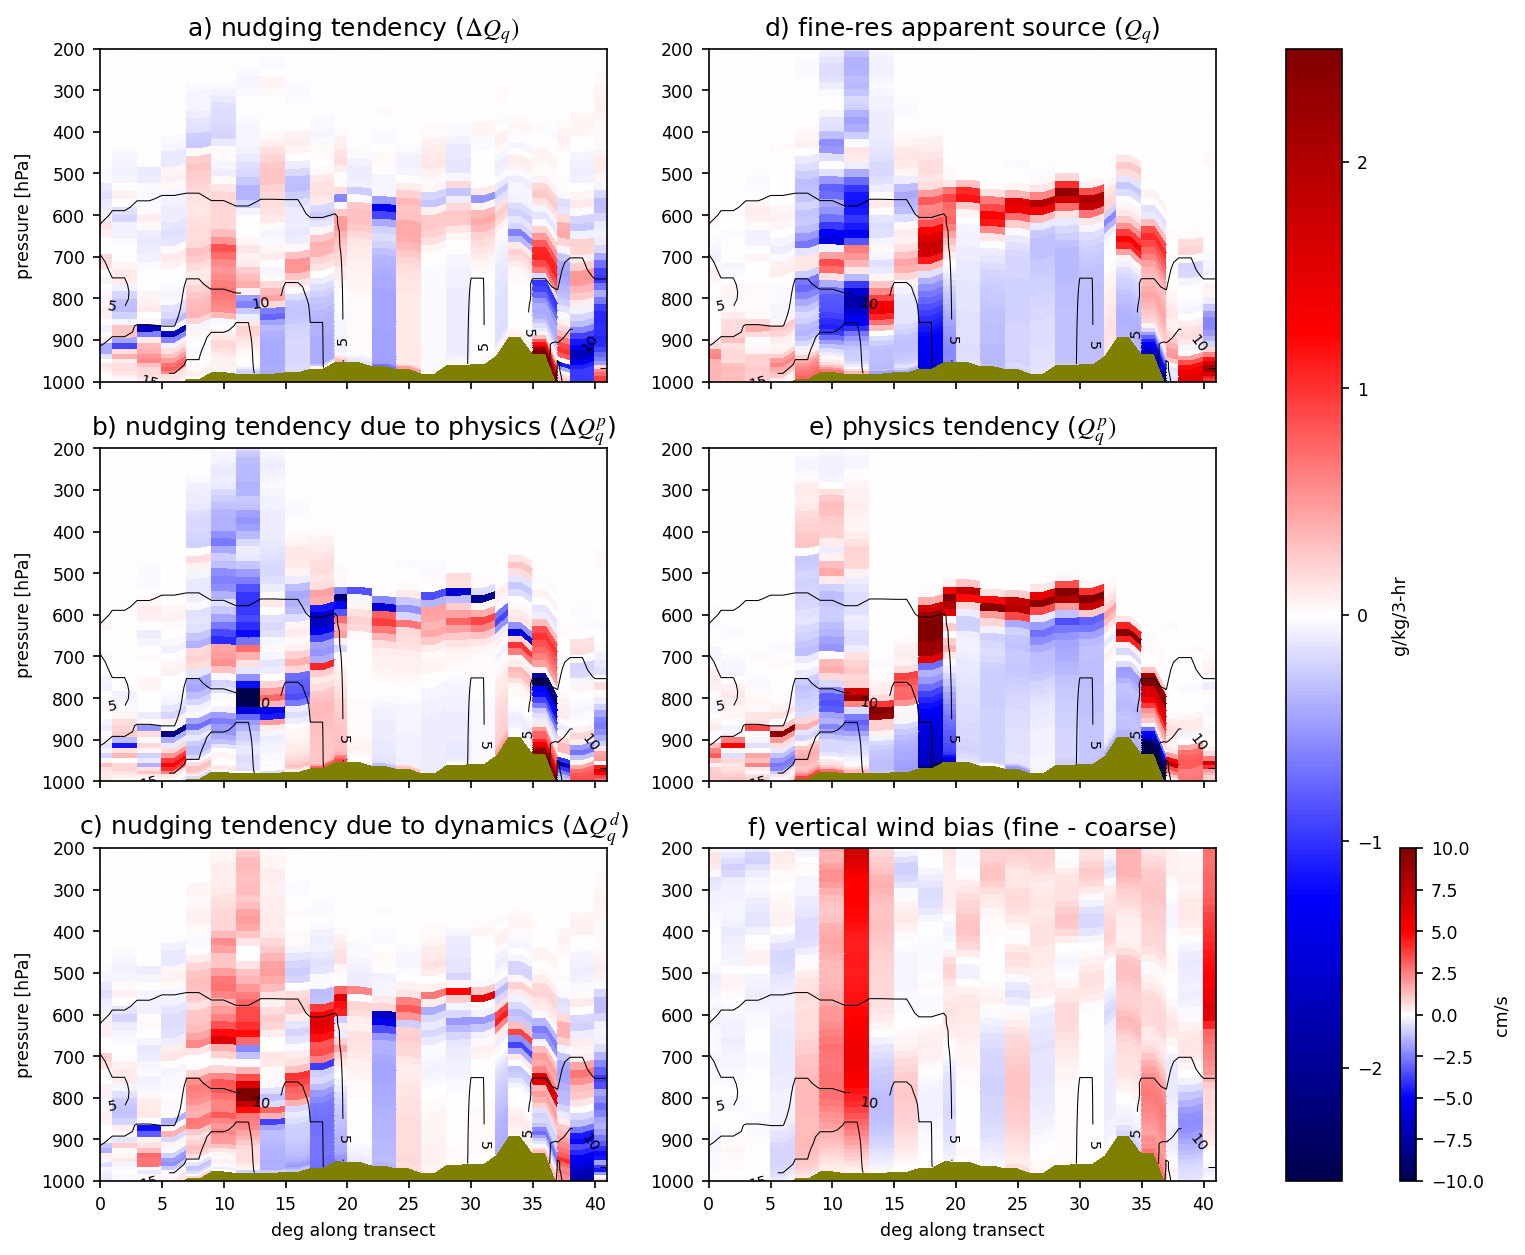

In [19]:
instantaneous_transect(sahara_moisture_tendency_xs_mapper, INSTANTANEOUS_TIMESTAMP)

Loading data for slice('20160805.023000', '20160810.023000', None)
[########################################] | 100% Completed | 12min 41.1s


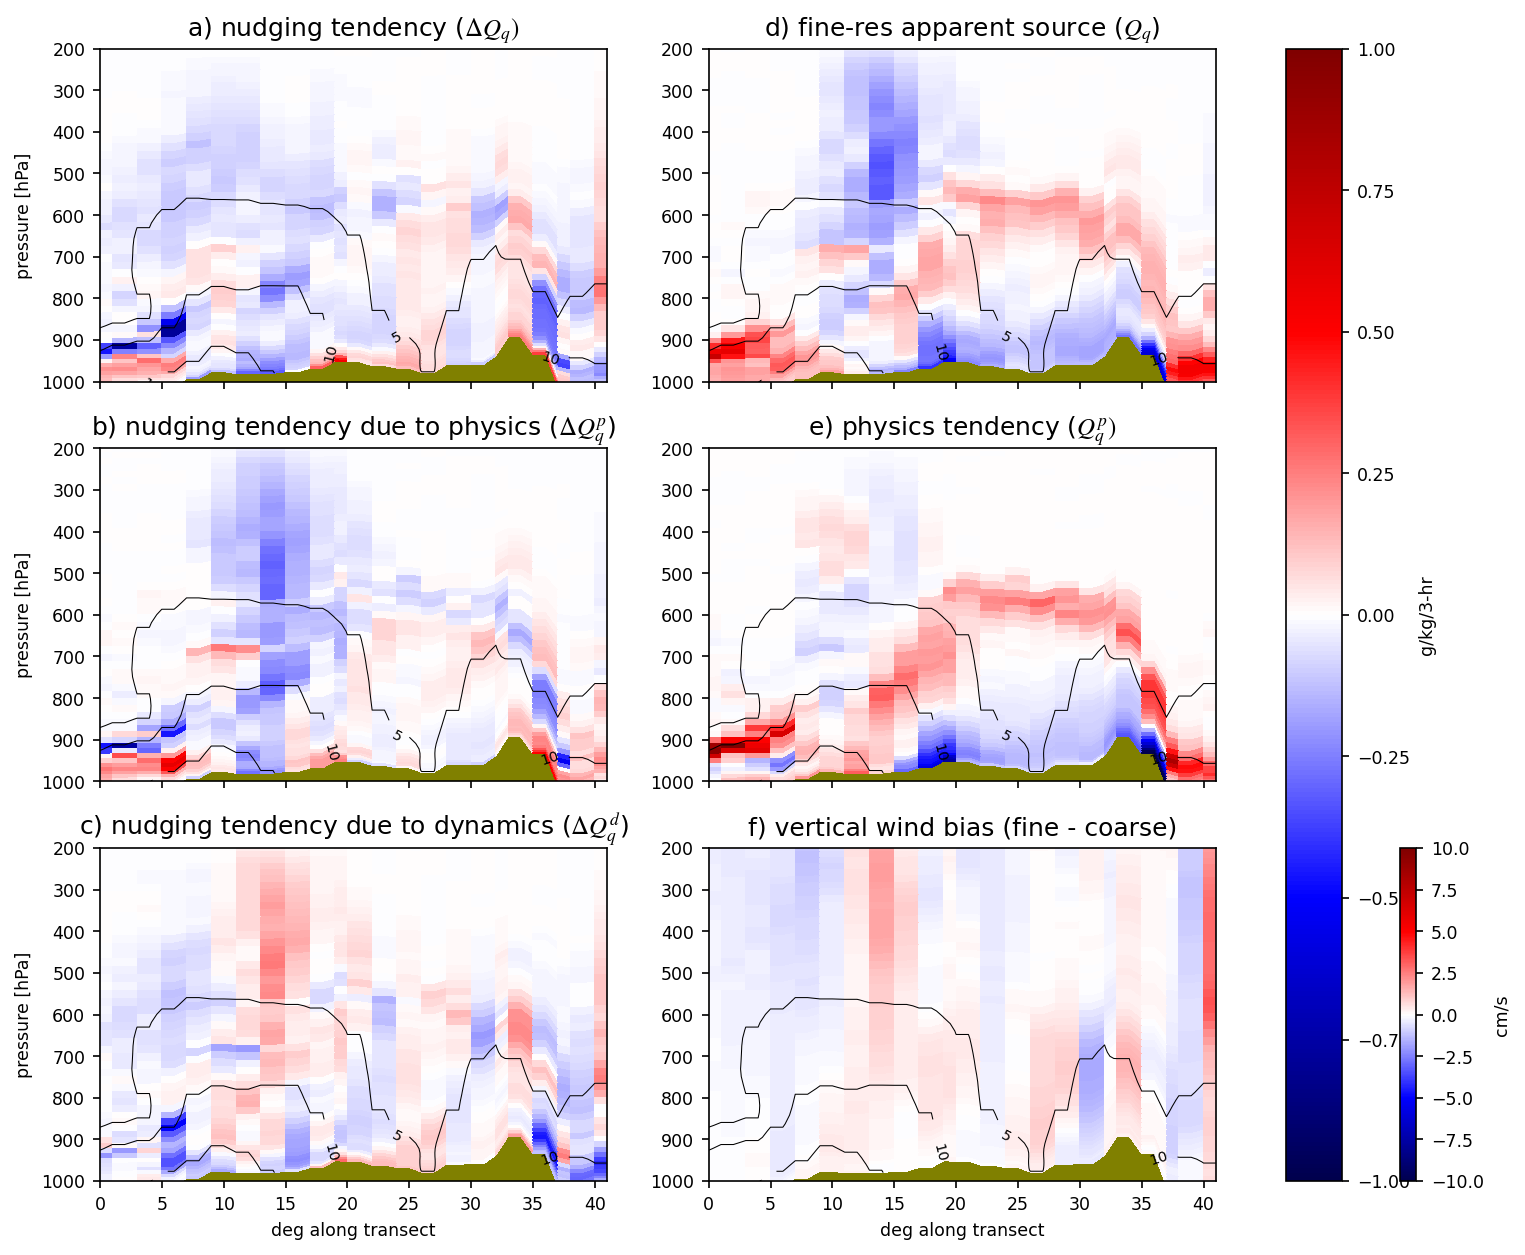

In [20]:
time_mean_transect(sahara_moisture_tendency_xs_mapper, TIME_MEAN_SLICE)

In [21]:
animate_transect(
    sahara_moisture_tendency_xs_mapper,
    TIME_MEAN_SLICE,
    func_animation_kwargs=dict(interval=250),
    dpi=100
)

Loading data for slice('20160805.023000', '20160810.023000', None)
[########################################] | 100% Completed | 10min 19.6s


Loading data for 20160805.143000
[########################################] | 100% Completed | 23.2s


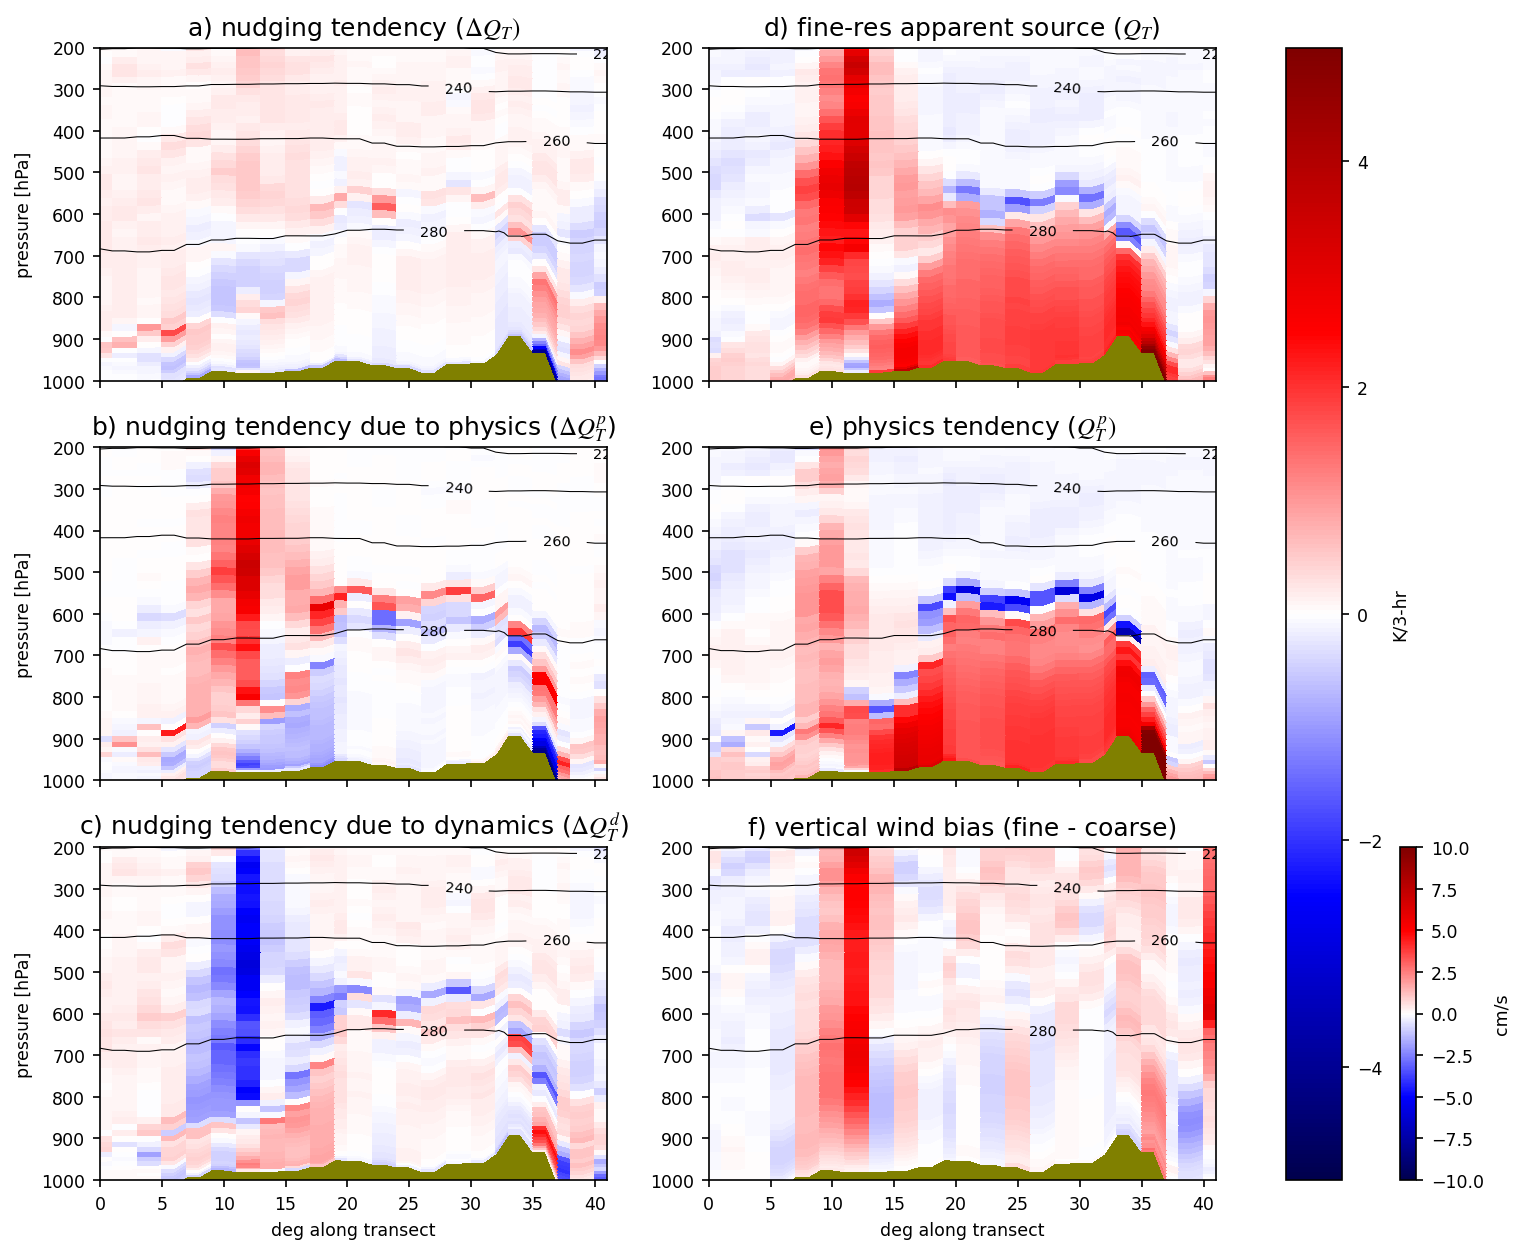

In [22]:
instantaneous_transect(sahara_temperature_tendency_xs_mapper, INSTANTANEOUS_TIMESTAMP, pcolor_kwargs=Q1_SCALE)

Loading data for slice('20160805.023000', '20160810.023000', None)
[########################################] | 100% Completed | 11min 51.8s


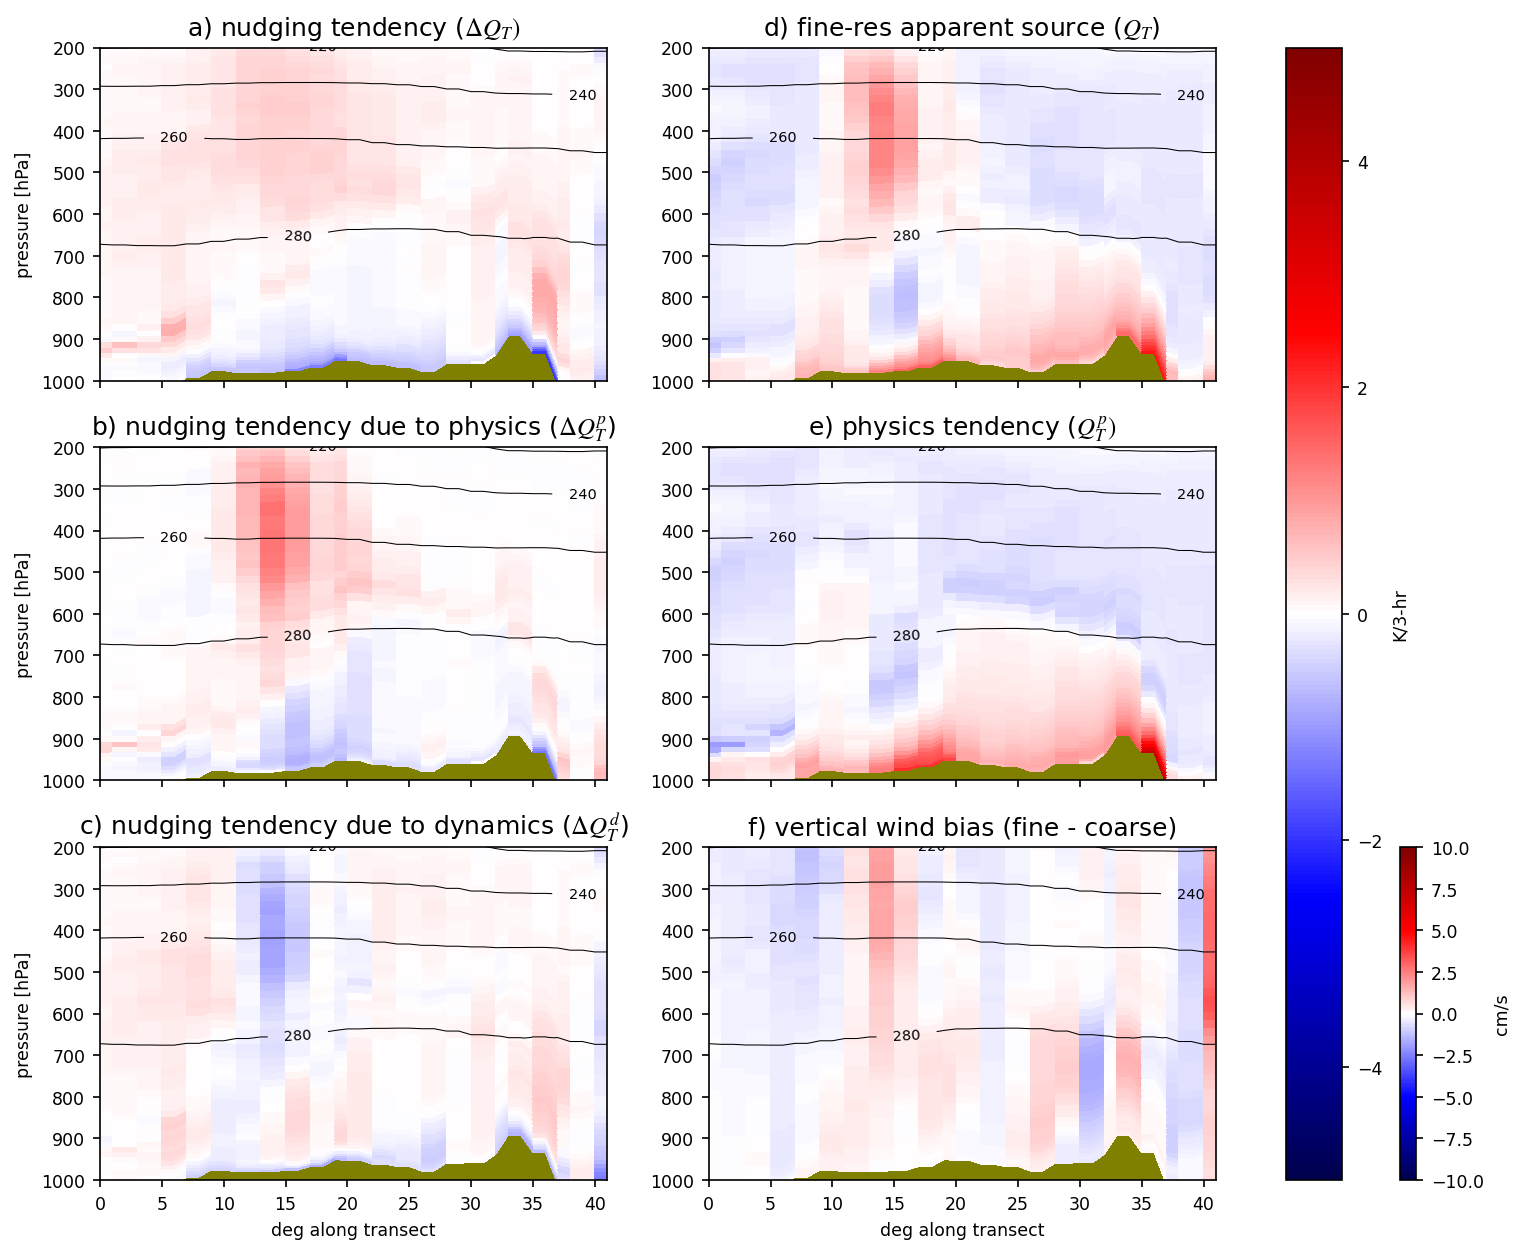

In [23]:
time_mean_transect(sahara_temperature_tendency_xs_mapper, TIME_MEAN_SLICE, pcolor_kwargs=Q1_SCALE)

In [24]:
animate_transect(
    sahara_temperature_tendency_xs_mapper,
    TIME_MEAN_SLICE,
    func_animation_kwargs=dict(interval=250),
    dpi=100,
    pcolor_kwargs=Q1_SCALE
)

Loading data for slice('20160805.023000', '20160810.023000', None)
[########################################] | 100% Completed |  9min 31.8s
